# Packages

In [1]:
# Core Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# import mgarch

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

# Additional Auxilliary Functions
from scipy.stats import kurtosis, skew, jarque_bera

# Cosmetics
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
from typing import List

# Read Data

In [2]:
# full data
start_date = "1995-01-01"
end_date = "2022-12-31"

price_long = pd.read_csv("data_clean/long_format_daily.csv")
price_long["Date"] = pd.to_datetime(price_long["Date"])
price_long = price_long.loc[(price_long["Date"] >= start_date) & (price_long["Date"] <= end_date), :]

# very short data for testing
price_long_test = price_long.loc[(price_long["Date"] >= '2022-01-01'), :]
price_wide_test = price_long_test.pivot(index='Date', columns='Ticker', values='Price')
return_wide_test = price_wide_test.pct_change().iloc[1:,:]

In [3]:
# data used to replicate paper results
start_date = "2010-01-01"
end_date = "2020-06-30"

price_long_paper = pd.read_csv("data_clean/long_format_daily_original_paper_data.csv")
price_long_paper["Date"] = pd.to_datetime(price_long_paper["Date"])
price_long_paper = price_long_paper.loc[(price_long_paper["Date"] >= start_date) & (price_long_paper["Date"] <= end_date), :]
price_wide_paper = price_long_paper.pivot(index='Date', columns='Ticker', values='Price')

# VTI, AGG, DBC, VIX

# Python Functions

## Optimization Framework - Traditional

In [4]:
def portfolio_optimization(returns, loss_func:str, cov_estimation:str='historical'):
    # return the portfolio weight for 1 rebalance period 
    def constraint_basic(weights):
        return np.sum(weights) - 1
    
    def constraint_long_only(weights):
        return weights    # make sure weights are positive
    
    def objective_variance(weights):
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return portfolio_volatility
    
    def objective_sharpe(weights):
        portfolio_return = np.dot(mean_returns, weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return - portfolio_return / portfolio_volatility
    
    def objective_markowitz3(weights):
        a = 1000 # hyperparameter tuning through grid search
        b = 1
        portfolio_return = np.dot(mean_returns, weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = portfolio_return / portfolio_volatility
        entropy = np.exp(-np.sum(weights * np.log(weights)))
        return -(a * sharpe + b * entropy) / (a + b)
    
    def objective_divers_ratio(weights):
        portfolio_variance = 0
        weighted_sum = 0
        for i in range(cov_matrix.shape[0]):
            portfolio_variance += weights[i]**2*cov_matrix[i][i]
            weighted_sum += weights[i]**2*cov_matrix[i][i]
            for j in range(cov_matrix.shape[0]):
                if i>j:
                    portfolio_variance+= 2*weights[i]*weights[j]*cov_matrix[i][j]
        DR = np.sqrt(weighted_sum/portfolio_variance)
        return - DR

    def objective_marginal_risk_contribution(weights):
        portfolio_TR = 0
        portfolio_variance = 0
        for i in range(cov_matrix.shape[0]):
            portfolio_variance += weights[i]**2*cov_matrix[i][i]
            RC_i = 2*weights[i]**2*cov_matrix[i][i]
            for j in range(cov_matrix.shape[0]):
                if j!=i:
                    portfolio_variance+= weights[i]*weights[j]*cov_matrix[i][j]
                    RC_i += weights[i]*weights[j]*cov_matrix[i][j]
            portfolio_TR+=RC_i
        return portfolio_TR/np.sqrt(portfolio_variance)
    
    # basic feature
    tickers = returns.columns
    date = returns.index[-1]
    num_assets = returns.shape[1]
    mean_returns = np.mean(returns, axis=0)
    annualized_vol = returns.std() * np.sqrt(252 / 66)
    
    # Covariance Matrix:
    if cov_estimation == 'historical':
        cov_matrix = np.cov(returns.T, ddof=1)
    if cov_estimation == 'regularized':
        c = 0.00005
        cov_matrix = np.cov(returns.T, ddof=1) 
        cov_matrix += c * np.eye(cov_matrix.shape[0])
    if cov_estimation == 'DCC_GARCH':
        vol = mgarch.mgarch()
        vol.fit(returns)
        ndays = 1
        cov_matrix = vol.predict(ndays)['cov']
    
    # calculate weight by minimizing objective, subject to constraint
    constraints = [{'type': 'eq', 'fun': constraint_basic}, {'type': 'ineq', 'fun': constraint_long_only}]
    init_weights = np.array([1 / num_assets] * num_assets)
    if loss_func == 'equal_weight':
        return pd.DataFrame({'Date':date, 
                             'Ticker':tickers, 
                             'Weight':init_weights, 
                             'Annualized_vol':annualized_vol
                            })
    objective = locals()['objective_' + loss_func] # call the objective function associated with input
    weights = minimize(objective, init_weights, method='SLSQP', constraints=constraints).x
    
    return pd.DataFrame({'Date':date, 
                         'Ticker':tickers, 
                         'Weight':weights, 
                         'Annualized_vol':annualized_vol
                        })

In [5]:
def optimize_portfolio(price_long, loss_func:str, cov_estimation:str='historical', period=66):
    price_wide = price_long.pivot(index='Date', columns='Ticker', values='Price')
    return_wide = price_wide.pct_change().iloc[1:,:] #drop 1st row
    n_rebalance = return_wide.shape[0] // period
    
    chunks = [return_wide.iloc[i:i+period, :] for i in range(0, period * n_rebalance, period)]
    weights = pd.DataFrame(columns=['Date', 
                                    'Ticker', 
                                    'Weight', 
                                    'Annualized_vol'])
    
    for chunk in chunks: # each chunk is a return data (wide format)
        na_threshold = 5 # drop ticker w/ >5 NaN, fill ticker w/ <=5 NaN with 0
        returns = chunk.dropna(thresh = period-na_threshold, axis=1)
        returns = returns.fillna(0)
        chunk_weights = portfolio_optimization(returns, loss_func, cov_estimation)
        weights = pd.concat([weights, chunk_weights], axis=0, ignore_index=True)
    
    weights = pd.merge(weights, price_long[['Date', 'Ticker', 'Price']], on=['Date', 'Ticker'], how='right')
    weights.sort_values('Date',inplace=True)
    weights["Weight"] = weights.groupby("Ticker")["Weight"].fillna(method='ffill',axis=0)
    weights["Annualized_vol"] = weights.groupby("Ticker")["Annualized_vol"].fillna(method='ffill',axis=0)
    return weights.reset_index(drop=True)

# def optimize_portfolio(price_long, loss_func:str, cov_estimation:str='historical', period=66):
#     price_wide = price_long.pivot(index='Date', columns='Ticker', values='Price')
#     return_wide = price_wide.pct_change().iloc[1:,:] #drop 1st row
#     n_rebalance = return_wide.shape[0] // period
    
#     chunks = [return_wide.iloc[i:i+period, :] for i in range(0, period * n_rebalance, period)]
#     weights = pd.DataFrame(columns=['Date', 
#                                     'Ticker', 
#                                     'Weight', 
#                                     'Annualized_vol'])
    
#     for chunk in chunks: # each chunk is a return data (wide format)
#         na_threshold = 5 # drop ticker w/ >5 NaN, fill ticker w/ <=5 NaN with 0
#         returns = chunk.dropna(thresh = period-na_threshold, axis=1)
#         returns = returns.fillna(0)
#         chunk_weights = portfolio_optimization(returns, loss_func, cov_estimation)
#         weights = pd.concat([weights, chunk_weights], axis=0, ignore_index=True)
    
#     weights = pd.merge(weights, price_long[['Date', 'Ticker', 'Price']], on=['Date', 'Ticker'], how='left')
#     return weights.reset_index(drop=True)

## Optimization Framework - LSTM

In [6]:
class Model:
    def __init__(self):
        self.data = None
        self.model = None
        
    def __build_model(self, input_shape, outputs):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='softmax')
        ])

        def sharpe_loss(_, y_pred):
            # make all time-series start at 1
            data = tf.divide(self.data, self.data[0])  
            
            # value of the portfolio after allocations applied
            portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
            
            portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

            sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)
            
            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)
            return -sharpe
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def get_allocations(self, data: pd.DataFrame):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets
        
        return: the allocations ratios for each of the given assets
        '''
        
        # data with returns
        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)
        
        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)
        
        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns))
        
        fit_predict_data = data_w_ret[np.newaxis,:]        
        self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=20, shuffle=False,
                       verbose=0
                      )
        return self.model.predict(fit_predict_data)[0]

In [7]:
def portfolio_optimization_LSTM(price_wide):
    # basic feature
    tickers = price_wide.columns
    date = price_wide.index[-1]
    return_wide = price_wide.pct_change().dropna()
    num_assets = price_wide.shape[1]
    annualized_vol = return_wide.std() * np.sqrt(252 / 65)
    
    model = Model()
    weights = model.get_allocations(price_wide)
    
    return pd.DataFrame({'Date':date, 
                         'Ticker':tickers, 
                         'Weight':weights, 
                         'Annualized_vol':annualized_vol
                        })

In [8]:
def optimize_portfolio_LSTM(price_long, period=66):
    price_wide = price_long.pivot(index='Date', columns='Ticker', values='Price')
    n_rebalance = price_wide.shape[0] // period
    
    chunks = [price_wide.iloc[i:i+period, :] for i in range(0, period * n_rebalance, period)]
    weights = pd.DataFrame(columns=['Date', 
                                    'Ticker', 
                                    'Weight', 
                                    'Annualized_vol'])
    
    for chunk in chunks: # each chunk is a price data (wide format)
        na_threshold = 5 # drop ticker w/ >5 NaN, fill ticker w/ <=5 NaN with 0
        prices = chunk.dropna(thresh = period-na_threshold, axis=1)
        prices = prices.fillna(method = 'ffill')
        prices = prices.iloc[-50:, :] # paper says only use that last 50 days info
        
        chunk_weights = portfolio_optimization_LSTM(prices)
        weights = pd.concat([weights, chunk_weights], axis=0, ignore_index=True)
    
    weights = pd.merge(weights, price_long[['Date', 'Ticker', 'Price']], on=['Date', 'Ticker'], how='right')
    weights.sort_values('Date',inplace=True)
    weights["Weight"] = weights.groupby("Ticker")["Weight"].fillna(method='ffill',axis=0)
    weights["Annualized_vol"] = weights.groupby("Ticker")["Annualized_vol"].fillna(method='ffill',axis=0)
    return weights.reset_index(drop=True)

## Backtest Framework

In [9]:
# Auxuliary Functions
def maximum_drawdown(pnl: pd.Series):
    nav = (1 + pnl).cumprod()
    running_max = nav.cummax()
    drawdown = (nav - running_max) / running_max
    max_drawdown = drawdown.min()
    max_drawdown_date = drawdown.idxmin()
    
    if max_drawdown == 0:
        return [drawdown, 0, np.NaN, np.NaN]
    
    def find_nearest_zeros(series):
        min_index = series.idxmin()
        left_zero_index = series[series <= 0].loc[:min_index][::-1].idxmax()
        righ_zero_index = series[series <= 0].loc[min_index:].idxmax()
        return left_zero_index, righ_zero_index
    
    drawdown_start_date, drawdown_end_date = find_nearest_zeros(drawdown)
    recovery_days = (drawdown_end_date - drawdown_start_date).total_seconds() / 86400.0
    
    return [drawdown, max_drawdown, max_drawdown_date, recovery_days]

In [10]:
def backtest(weight_long):
    data = weight_long.copy()
    data["ret"] = data.groupby("Ticker")["Price"].transform(lambda x: x.shift(-1)/x -1)
    data["pnl"] = data["ret"] * data["Weight"]
    port_pnl = data.groupby("Date").apply(lambda x: np.sum(x["pnl"]))
    port_pnl.index = pd.to_datetime(port_pnl.index)
    port_nav = (1 + port_pnl).cumprod()
    port_vol = weight_long.groupby('Date').apply(lambda x: np.sqrt(np.sum((x['Weight'] * x['Annualized_vol'])**2)))
    
    def calc_var(port_pnl, confidence_level = 0.05):
        sorted_pnl = port_pnl.sort_values()
        index = int(confidence_level * len(sorted_pnl))
        return sorted_pnl.iloc[index]
    
    def calc_cvar(port_pnl, confidence_level = 0.05):
        var = calc_var(port_pnl, confidence_level)
        pnl_below_var = port_pnl[port_pnl <= var]
        return pnl_below_var.mean()
    
    avg_annual_ret = port_pnl.mean() * 252
    avg_annual_std = port_pnl.std() * np.sqrt(252)
    s = skew(port_pnl)
    k = kurtosis(port_pnl)
    sharpe_ratio = avg_annual_ret / avg_annual_std
    adj_sharpe_ratio = sharpe_ratio * (1 + s/6*sharpe_ratio - k/24*sharpe_ratio**2)
    drawdown_results = maximum_drawdown(port_pnl)
    
    shannon_entropy = data.groupby("Date")["Weight"].apply(lambda x: np.exp(-np.sum(x * np.log(x))))
    shannon_entropy.index = port_pnl.index
    weighted_vol = weight_long.groupby('Date').apply(lambda x: np.sum(x['Weight'] * x['Annualized_vol']))
    diversification_ratio = weighted_vol / port_vol
    
    return {'avg annualized ret': avg_annual_ret,
            'avg annualized std': avg_annual_std,
            'sharpe ratio': sharpe_ratio, 
            'adjusted sharpe ratio': adj_sharpe_ratio,
            'skewness': s,
            'excess kurtosis': k,
            'maximum drawdown': drawdown_results[1],
            'maximum drawdown length (days)': drawdown_results[3],
            'VaR (95%)': calc_var(port_pnl),
            'CVaR (95%)': calc_cvar(port_pnl),
            # 'shannon entropy mean': shannon_entropy.mean(),
            # 'shannon entropy std': shannon_entropy.std(),
            # 'diversification ratio mean': diversification_ratio.mean(),
            # 'diversification ratio std': diversification_ratio.std(),
            'effective number of uncorrelated bets': np.square(diversification_ratio).mean(),
            # time series data below
            'pnl': port_pnl,
            'nav': port_nav,
            # 'annualized_realized_vol': port_vol,
            'drawdown': drawdown_results[0],
            # 'shannon_entropy': shannon_entropy,
            # 'diversification_ratio': diversification_ratio,
           }


def comparison_table(result_list):
    # this compiles all numerical results (not a timeseries)
    comparison = pd.DataFrame()
    for result in result_list:
        float_values = {key: value for key, value in result.items() if isinstance(value, float)}
        tmp_df = pd.DataFrame(float_values.values(), index=float_values.keys())
        comparison = pd.concat([comparison, tmp_df], axis = 1)
    return comparison

In [11]:
def display_backtest_results(list_of_weight_long, list_of_names = []):
    list_of_results = []
    for weight_long in list_of_weight_long:
        list_of_results.append(backtest(weight_long))

    table = comparison_table(list_of_results)
    if list_of_names != []:
        table.columns = list_of_names
    display(table)

    plot_lists = ['nav', 
                  'pnl', 
                  # 'annualized_realized_vol', 
                  'drawdown',
                  # 'shannon_entropy', 
                  # 'diversification_ratio'
                 ]
    fig, axs = plt.subplots(len(plot_lists), figsize = (10, 5*len(plot_lists)))
    for i in range(len(plot_lists)):
        for j in range(len(list_of_results)):
            if list_of_names != []:
                axs[i].plot(list_of_results[j][plot_lists[i]], label = f"{list_of_names[j]}")
            else:
                axs[i].plot(list_of_results[j][plot_lists[i]], label = f"Strategy {j + 1}")
        axs[i].legend()
        axs[i].set_title(f"{plot_lists[i]}");

# Paper Data - Static Allocation

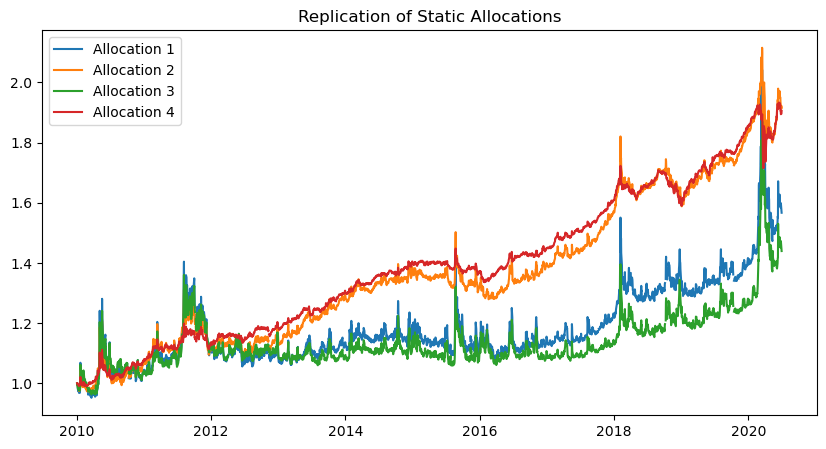

In [12]:
VTI = price_wide_paper['VTI'] / price_wide_paper['VTI'][0]
AGG = price_wide_paper['AGG'] / price_wide_paper['AGG'][0]
DBC = price_wide_paper['DBC'] / price_wide_paper['DBC'][0]
VIX = price_wide_paper['VIX'] / price_wide_paper['VIX'][0]

assets = [VTI, AGG, DBC, VIX]

allocation_1 = [1/4, 1/4, 1/4, 1/4]
allocation_2 = [1/2, 1/10, 1/5, 1/5]
allocation_3 = [1/10, 1/2, 1/5, 1/5]
allocation_4 = [2/5, 2/5, 1/10, 1/10]


NAV_1 = pd.Series(pd.DataFrame(assets).T.to_numpy() @ np.array(allocation_1), index = price_wide_paper.index)
NAV_2 = pd.Series(pd.DataFrame(assets).T.to_numpy() @ np.array(allocation_2), index = price_wide_paper.index)
NAV_3 = pd.Series(pd.DataFrame(assets).T.to_numpy() @ np.array(allocation_3), index = price_wide_paper.index)
NAV_4 = pd.Series(pd.DataFrame(assets).T.to_numpy() @ np.array(allocation_4), index = price_wide_paper.index)

plt.figure(figsize = (10, 5))
plt.plot(NAV_1, label = 'Allocation 1')
plt.plot(NAV_2, label = 'Allocation 2')
plt.plot(NAV_3, label = 'Allocation 3')
plt.plot(NAV_4, label = 'Allocation 4')
plt.legend()
plt.title("Replication of Static Allocations");

# Paper Data - LSTM

In [13]:
%%time
tf.keras.utils.set_random_seed(100)
weight_paper_LSTM = optimize_portfolio_LSTM(price_long_paper, period = 252)

1/1 [==============================] - 0s 366ms/step
CPU times: total: 1min 31s
Wall time: 25 s


,LSTM
avg annualized ret,0.178113
avg annualized std,0.289242
sharpe ratio,0.615791
adjusted sharpe ratio,0.621821
skewness,1.161084
excess kurtosis,6.922347
maximum drawdown,-0.290894
maximum drawdown length (days),369.000000
VaR (95%),-0.024460
CVaR (95%),-0.037719


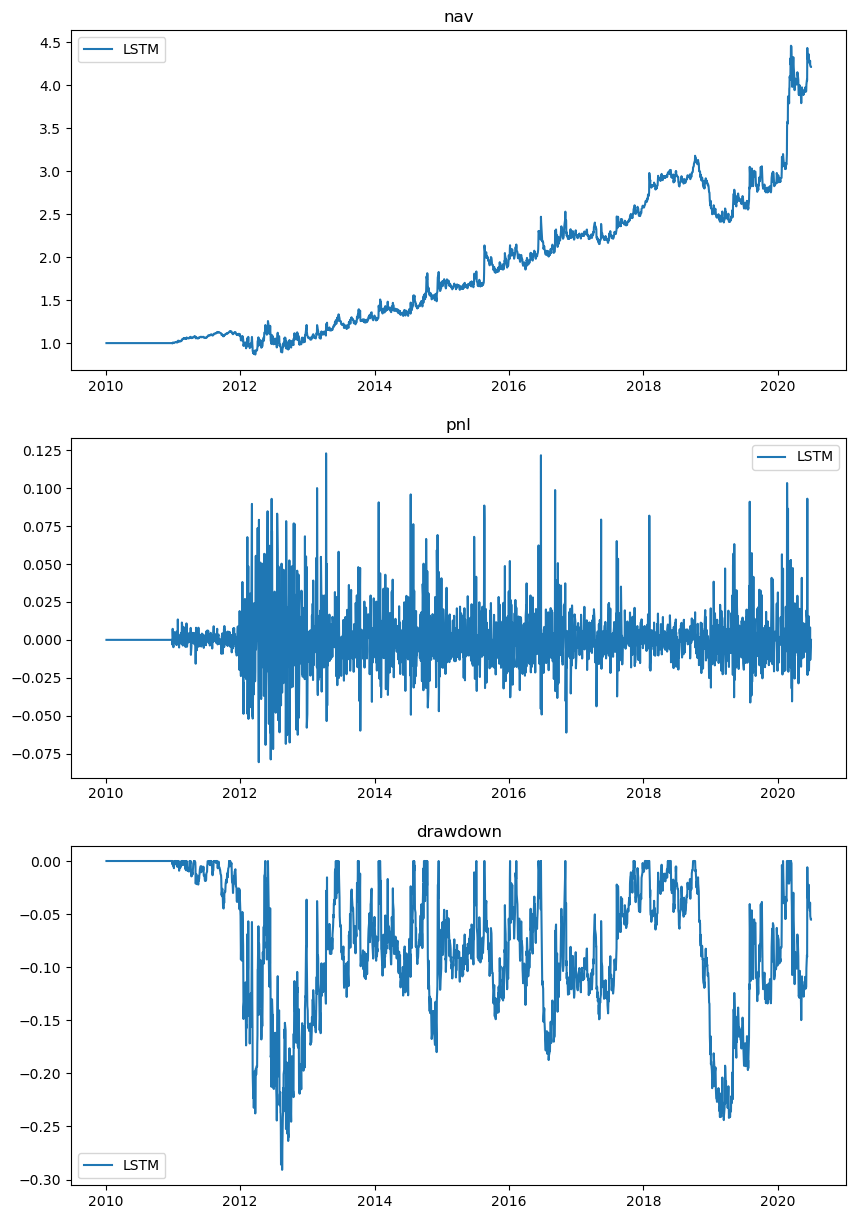

In [14]:
display_backtest_results([weight_paper_LSTM], ["LSTM"])

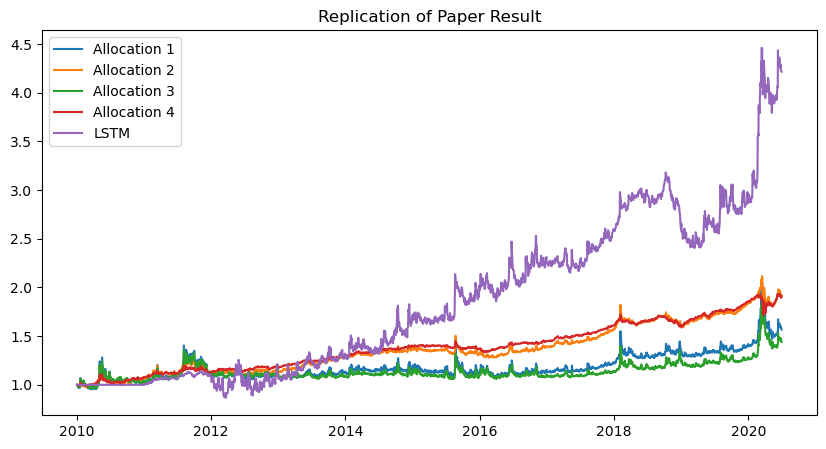

In [15]:
plt.figure(figsize = (10, 5))
plt.plot(NAV_1, label = 'Allocation 1')
plt.plot(NAV_2, label = 'Allocation 2')
plt.plot(NAV_3, label = 'Allocation 3')
plt.plot(NAV_4, label = 'Allocation 4')
plt.plot(backtest(weight_paper_LSTM)['nav'], label = 'LSTM')
plt.legend()
plt.title("Replication of Paper Result");

# Paper Data - Traditional

In [16]:
weight_paper_variance = optimize_portfolio(price_long_paper, loss_func='variance', period = 252)
weight_paper_sharpe = optimize_portfolio(price_long_paper, loss_func='sharpe', period = 252)
weight_paper_markowitz3 = optimize_portfolio(price_long_paper, loss_func='markowitz3', period = 252)
# weight_paper_DCC_GARCH = optimize_portfolio(price_long_paper, loss_func='variance', cov_estimation='DCC_GARCH', period = 252)
weight_paper_DR = optimize_portfolio(price_long_paper, loss_func='divers_ratio', period = 252)
weight_paper_MRC = optimize_portfolio(price_long_paper, loss_func='marginal_risk_contribution', period = 252)

,LSTM,minVar,maxSharpe,Markowitz 3.0,maxDR,minMRC
avg annualized ret,0.178113,0.048175,0.090144,0.096711,0.125583,0.031685
avg annualized std,0.289242,0.032714,0.056425,0.150967,0.072441,0.029286
sharpe ratio,0.615791,1.472622,1.597587,0.640611,1.733588,1.081949
adjusted sharpe ratio,0.621821,-3.021787,-0.696741,-0.064575,-3.293968,0.207521
skewness,1.161084,-1.153626,0.418639,4.055908,0.477968,-1.158703
excess kurtosis,6.922347,30.642611,14.552513,89.702504,24.262412,12.285946
maximum drawdown,-0.290894,-0.087113,-0.103538,-0.240439,-0.144964,-0.070101
maximum drawdown length (days),369.000000,82.000000,80.000000,132.000000,80.000000,96.000000
VaR (95%),-0.024460,-0.002717,-0.004577,-0.007049,-0.005442,-0.002763
CVaR (95%),-0.037719,-0.004624,-0.007862,-0.020396,-0.009765,-0.004269


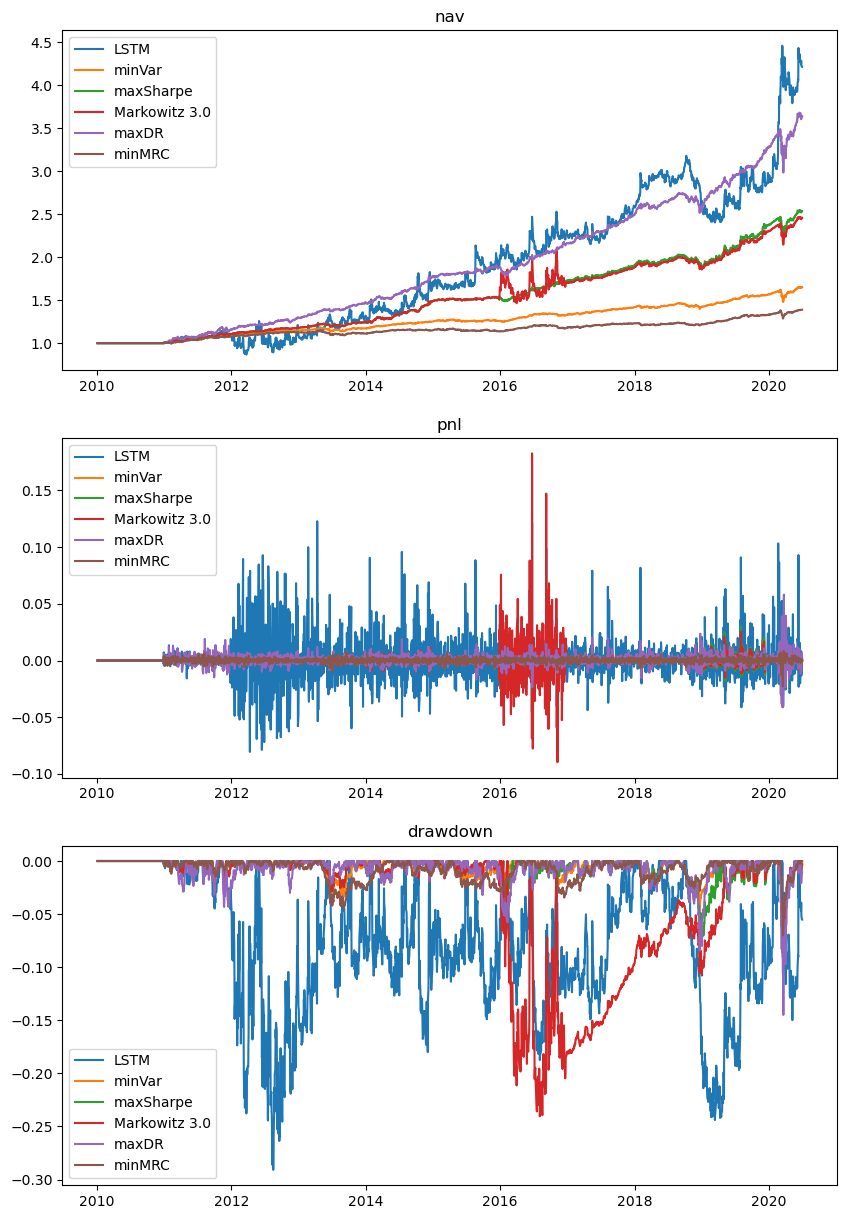

In [17]:
display_backtest_results(
    [weight_paper_LSTM,
     weight_paper_variance,
     weight_paper_sharpe,
     weight_paper_markowitz3,
     weight_paper_DR,
     weight_paper_MRC
    ],
    ["LSTM", "minVar", "maxSharpe", "Markowitz 3.0", "maxDR", "minMRC"]
)

# Better Data

In [18]:
# weight_better_LSTM = optimize_portfolio_LSTM(price_long, period = 252)
# weight_better_variance = optimize_portfolio(price_long, loss_func='variance', period = 252)
# weight_better_sharpe = optimize_portfolio(price_long, loss_func='sharpe', period = 252)
# weight_better_markowitz3 = optimize_portfolio(price_long, loss_func='markowitz3', period = 252)
# weight_better_DR = optimize_portfolio(price_long, loss_func='divers_ratio', period = 252)
# weight_better_MRC = optimize_portfolio(price_long, loss_func='marginal_risk_contribution', period = 252)

In [19]:
# display_backtest_results(
#     [weight_better_LSTM,
#      weight_better_variance,
#      weight_better_sharpe,
#      weight_better_markowitz3,
#      weight_better_DR,
#      weight_better_MRC
#     ],
#     ["LSTM", "minVar", "maxSharpe", "Markowitz 3.0", "maxDR", "minMRC"]
# )